In [1]:
import os
print(os.listdir("images"))

from os import walk
for (dirpath, dirnames, filenames) in walk("assignment-5/images"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)

['apple', '.DS_Store', 'guava']


In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn           
import torch.optim as optim     
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm 
import time


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(40)
np.random.seed(40)

# Single Block VGG
VGG3 = [32, 'M', 64, 'M', 128, 'M']

class VGG_net(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 2):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_layers = self.create_conv_layers(VGG3)

        self.fcs = nn.Sequential(
            # nn.Linear(56*56*32, 4096), # This has to be put with care
            nn.Linear(28*28*128, 128),
            nn.ReLU(),
            # nn.Dropout(p = 0.5),
            # nn.Linear(4096, 4096),
            # nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(128, out_channels)
        )
    
    def forward(self, x):
        # print("shape1: ",x.shape)
        x = self.conv_layers(x)
        # print("shape2: ",x.shape)
        x = x.reshape(x.shape[0], -1)
        # print("shape3: ",x.shape)
        x = self.fcs(x)
        # print("shape4: ",x.shape)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                                    kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                                    # nn.BatchNorm2d(x),
                                    nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]
        
        return nn.Sequential(*layers)

# VGG MODEL 
model = VGG_net(in_channels=3, out_channels=2).to(device)

In [8]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 0.001
batch_size = 16
num_epochs = 5

# Loading and Processing the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 256x256 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image
])

dataset = datasets.ImageFolder("images", transform=transform)
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and test splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=test_sampler)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = learning_rate)


# Training the Network
start = time.time()
Training_loss = 0

for epochs in range(num_epochs):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data = data.to(device = device)
        target = target.to(device = device)
        # data shape is 64,1,28,28

        # Feed Forward
        score = model(data)
        loss = criterion(score, target)
        Training_loss = loss

        # Backprop
        optimiser.zero_grad()
        loss.backward()

        # Gradient Descent
        optimiser.step()

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() # We set the model to evaluation mode

    with torch.no_grad(): # We don't need to calculate the gradient
        for x, y in loader:
            x = x.to(device = device)
            y = y.to(device = device)
            # x = x.reshape(x.shape[0], -1) # We don't need to reshape the data

            scores = model(x)
            _, predictions = scores.max(1) # We get the index of the maximum value
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")

    model.train() # We can check the accuracy while training also, use it then
    return float(num_correct)/float(num_samples)*100

end = time.time()

print("Train Accuracy ")
check_accuracy(train_loader, model)
print("Test Accuracy ")
check_accuracy(test_loader, model)

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Train Accuracy 
Got 134 / 160 with accuracy 83.75
Test Accuracy 
Got 30 / 40 with accuracy 75.00


75.0

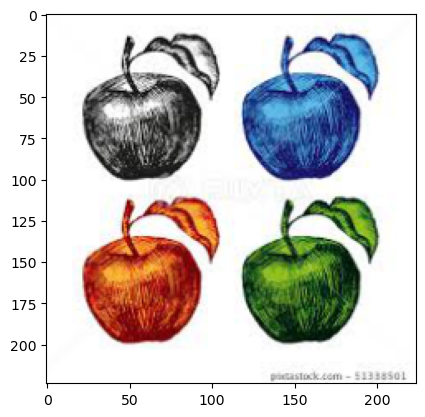

Gauva


In [20]:
# Trying FUN images:-
from PIL import Image
trial_image = Image.open('images/apple/apple fruit28.jpg')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 256x256 pixels
    transforms.ToTensor()#,  # Convert the image to a PyTorch tensor
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the image
])

transformed_image = transform(trial_image)

plt.imshow(transformed_image.permute(1, 2, 0))
plt.show()

if model(transformed_image.unsqueeze(0).to(device)).argmax() == 0:
    print("Apple")
else:
    print("Gauva")